#  06 - Final Model Evaluation & Explainability

This notebook evaluates the final tuned model selected and explains its behavior
using SHAP interpretability techniques.

Since the problem involves medical classification (malignant vs benign tumors),
model transparency is essential. We analyze:

- Generalization metrics (Accuracy, Precision, Recall, F1, ROC-AUC)
- Confusion matrix and classification report
- ROC and Precision–Recall curves
- SHAP global feature importance
- SHAP local explanations for individual predictions

This step completes the analytical component of the project.

In [1]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, classification_report,
    confusion_matrix, precision_recall_curve
)

import joblib
import shap

from src.config import RANDOM_STATE
# consistency
np.random.seed(RANDOM_STATE)

# prediction pipeline
from src.inference.predict import PredictionPipeline

## 1. Loading the Final Model and Processed Data

We load the complete bundle saved in Step 05, which contains:

- the tuned model  
- the trained scaler  
- the final selected feature names  

This ensures full reproducibility and guarantees that the exact same preprocessing used during training is applied during evaluation.


In [2]:
# Load bundle (model + scaler + features)
bundle = joblib.load("../src/models/final_model.pkl")

model = bundle["model"]
scaler = bundle["scaler"]
features = list(bundle["features"])

# Load preprocessed data
X_train = pd.read_csv("../data/processed/X_train_preprocessed.csv")
X_test  = pd.read_csv("../data/processed/X_test_preprocessed.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()
y_test  = pd.read_csv("../data/processed/y_test.csv").squeeze()

# Select the final feature subset
X_test_sel = X_test[features]
X_train_sel = X_train[features]

## 2. Final Predictions

Since the data is already scaled from preprocessing, we can directly generate predictions and probabilities.


In [3]:
pred = model.predict(X_test_sel)
prob = model.predict_proba(X_test_sel)[:, 1]

## 3. Performance Metrics

These metrics reflect the model's generalization ability on unseen data.

These metrics offer complementary perspectives:
- **Precision** penalizes unnecessary malignant predictions
- **Recall** is critical for identifying malignant tumors
- **ROC-AUC** reflects overall separability in probabilistic space

In [4]:
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score", "ROC AUC"],
    "Value": [
        accuracy_score(y_test, pred),
        precision_score(y_test, pred),
        recall_score(y_test, pred),
        f1_score(y_test, pred),
        roc_auc_score(y_test, prob)
    ]
})

metrics_df["Value (%)"] = metrics_df["Value"] * 100
metrics_df

,Metric,Value,Value (%)
0,Accuracy,0.973684,97.368421
1,Precision,1.000000,100.000000
2,Recall,0.928571,92.857143
3,F1-score,0.962963,96.296296
4,ROC AUC,0.992394,99.239418


### 3.1 Confusion Matrix and Classification Report

The confusion matrix and classification report reveal per-class performance and highlight the distribution of prediction errors.


In [5]:
report_df = pd.DataFrame(classification_report(y_test, pred, output_dict=True)).T
report_df.head()

,precision,recall,f1-score,support
0,0.960000,1.000000,0.979592,72.000000
1,1.000000,0.928571,0.962963,42.000000
accuracy,0.973684,0.973684,0.973684,0.973684
macro avg,0.980000,0.964286,0.971277,114.000000
weighted avg,0.974737,0.973684,0.973465,114.000000


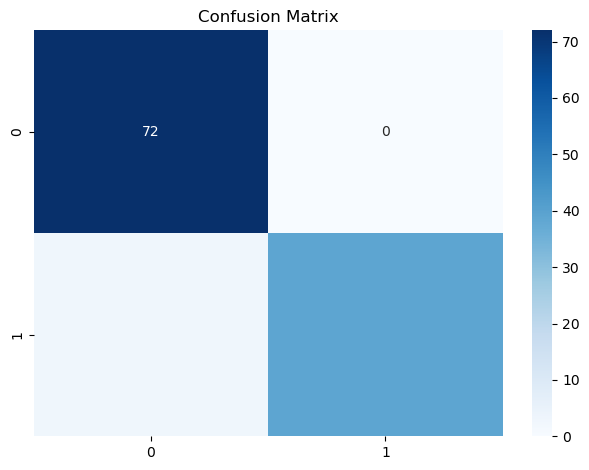

In [14]:
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("../imgs/confusion_matrix.png", dpi=150)
plt.show()

### 3.2 ROC Curve

The ROC curve illustrates the trade-off between sensitivity and specificity.
Higher AUC indicates better class separability.


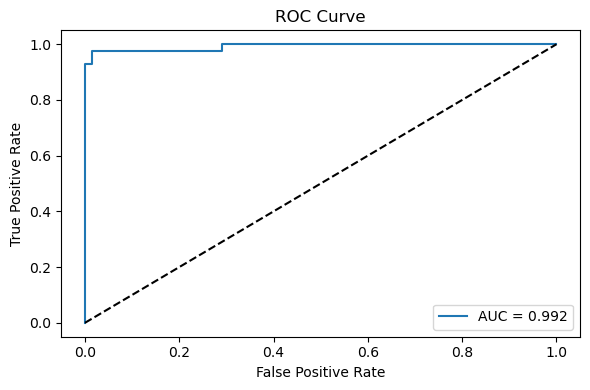

In [15]:
fpr, tpr, _ = roc_curve(y_test, prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig("../imgs/roc_curve.png", dpi=150)
plt.show()

### 3.3 Precision–Recall Curve

The PR curve is useful for imbalanced datasets and highlights the model's ability to avoid false negatives.


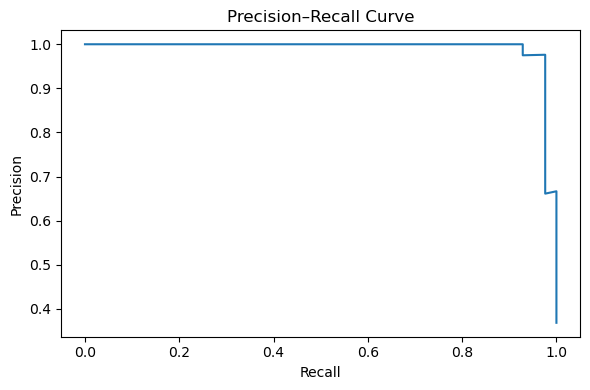

In [8]:
precision, recall, _ = precision_recall_curve(y_test, prob)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.tight_layout()
plt.show()

## 4. Global Explainability with SHAP (TreeExplainer)

TreeExplainer efficiently calculates Shapley values for Gradient Boosting models.
The beeswarm plot below highlights how each feature contributes to the model's predictions across the entire test set.

SHAP provides additive feature attributions grounded in cooperative game theory.
TreeExplainer efficiently computes Shapley values for tree-based models such as Gradient Boosting, offering fast and consistent global interpretability.

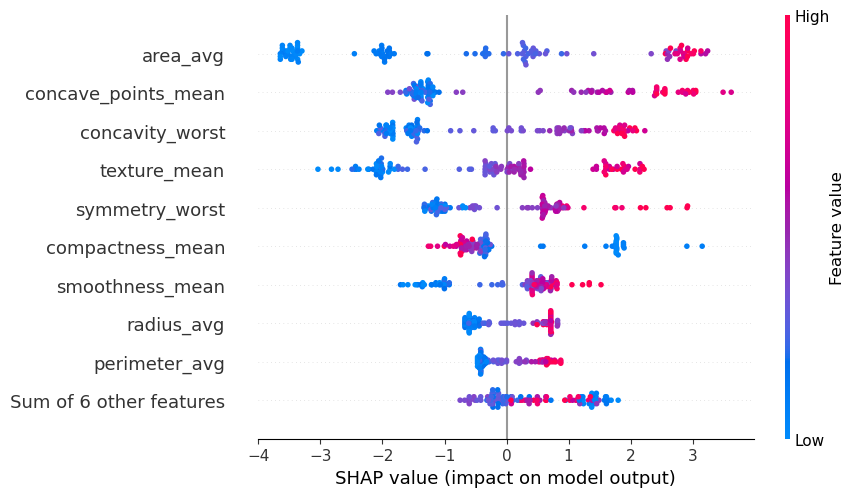

<Figure size 640x480 with 0 Axes>

In [20]:
explainer = shap.TreeExplainer(model)

# IMPORTANT: use the new API (returns shap.Explanation)
shap_values = explainer(X_test_sel)

shap.plots.beeswarm(shap_values)
plt.savefig("../imgs/shap_summary.png", dpi=150)

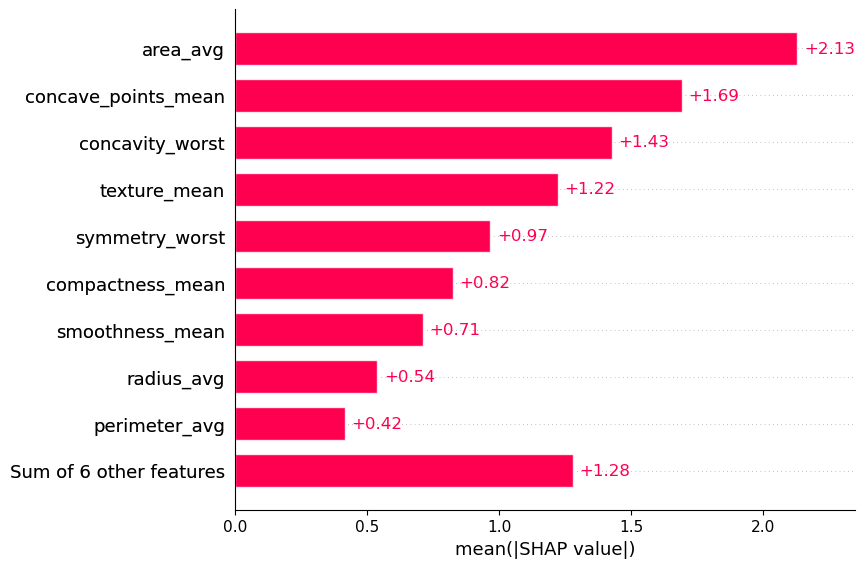

In [10]:
shap.plots.bar(shap_values)

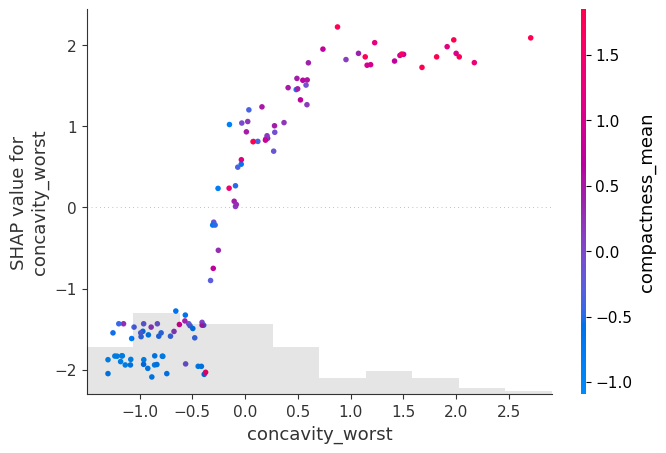

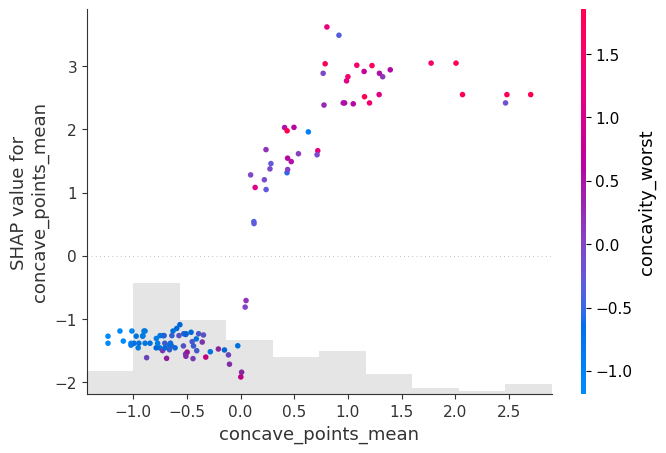

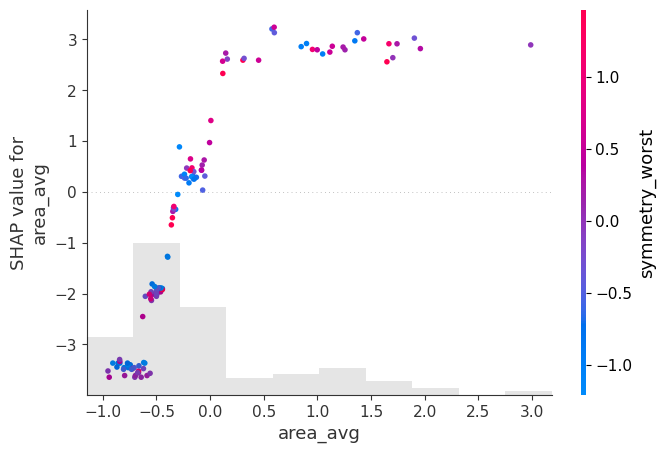

In [11]:
mean_abs = np.abs(shap_values.values).mean(axis=0)
top_idx = np.argsort(mean_abs)[-3:]
top_features = [features[i] for i in top_idx]

for feat in top_features:
    shap.plots.scatter(shap_values[:, feat], color=shap_values)

## 5. Local Explainability

Local explanations are essential when model decisions may influence clinical intervention.
The waterfall plot decomposes a single prediction into feature-level contributions, showing how the model transitions from the baseline probability to the final outcome..

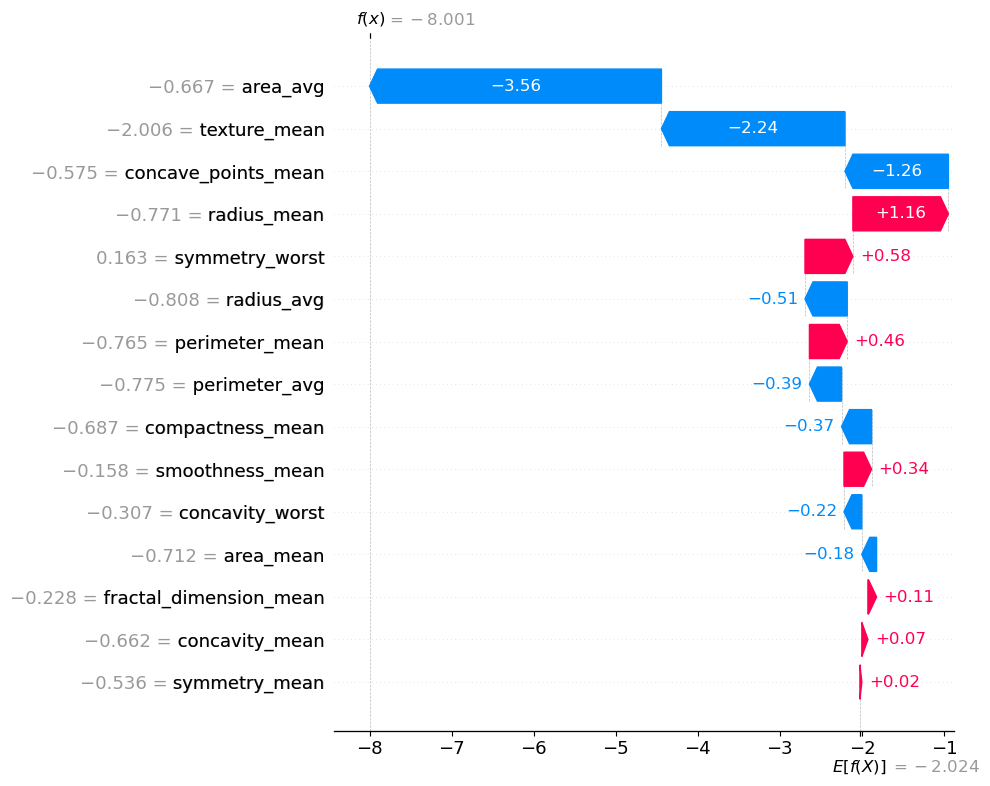

In [12]:
sample_idx = 0
shap.plots.waterfall(shap_values[sample_idx], max_display=15)

## 6. Error Analysis

We inspect false positives and false negatives to understand patterns where the model struggles
— an essential step before deploying a medical classification system.

False negatives represent malignant tumors incorrectly predicted as benign, which poses the highest clinical risk.  
False positives are less dangerous clinically but may lead to unnecessary exams or biopsies.


In [13]:
df_eval = X_test_sel.copy()
df_eval["true"] = y_test.values
df_eval["pred"] = pred

false_pos = df_eval[(df_eval["true"] == 0) & (df_eval["pred"] == 1)]
false_neg = df_eval[(df_eval["true"] == 1) & (df_eval["pred"] == 0)]

false_pos_df = false_pos.reset_index(drop=True)
false_neg_df = false_neg.reset_index(drop=True)

print(f"False Positives ({len(false_pos_df)} cases): patients incorrectly flagged as malignant")
display(false_pos_df.head())

print(f"\nFalse Negatives ({len(false_neg_df)} cases): malignant cases incorrectly predicted as benign — highest clinical risk")
display(false_neg_df.head())


False Positives (0 cases): patients incorrectly flagged as malignant


,concave_points_mean,concavity_worst,symmetry_worst,radius_avg,perimeter_avg,area_avg,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,true,pred



False Negatives (3 cases): malignant cases incorrectly predicted as benign — highest clinical risk


,concave_points_mean,concavity_worst,symmetry_worst,radius_avg,perimeter_avg,area_avg,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,true,pred
0,0.135598,1.075533,-0.169335,-0.347811,-0.271780,-0.335955,-0.191902,0.327188,-0.154552,-0.278811,0.392267,0.402317,0.209730,-0.343902,0.211863,1,0
1,0.042263,0.012905,-0.515510,-0.171611,-0.150325,-0.238331,-0.102395,-0.846418,-0.072332,-0.209649,0.329304,0.448741,-0.138396,-0.553926,0.422981,1,0
2,-0.104045,0.197012,-0.417056,0.043735,-0.056970,-0.049216,-0.155540,1.297805,-0.168727,-0.213537,-0.077861,-0.347716,-0.035956,-0.745845,-0.575162,1,0


## 7. Conclusion

The Gradient Boosting model shows strong generalization capacity and produces consistent,
interpretable predictions using SHAP TreeExplainer.

Key insights include:

- Global SHAP values reveal the most influential predictors of malignancy.
- Local explanations provide transparent justification for individual predictions.
- Error analysis highlights specific cases where caution is required.
- The evaluation demonstrates both high predictive performance and consistent decision behavior.
- The model relies on physiologically meaningful predictors (e.g., concavity, radius, area), increasing trustworthiness.
- Explainability confirms the model is stable and interpretable enough for further clinical validation.

Overall, the final model demonstrates excellent predictive performance, clinically meaningful feature behavior, and strong interpretability under SHAP analysis — supporting its suitability for deployment and further validation.
